In [1]:
import os
import getpass
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Model Liberay
import rf_model

# Random Forrest

**How to read this notebook:**

---

1. **Data**  
We load and prepare the dataset for modeling, including setting the target (inflation) and explanatory variables.  
---

2. **Forecast**  
We apply the Random Forrest algoritme to forecast inflation *h* months ahead from a given point in time (*last_observation_date*), using a fixed training window of *window_length* months.  

    2.1. **Variable Selection**  
    After fitting, we examine the non-zero coefficients to identify which explanatory variables drive the forecast at horizon *h*.

---

3. **Rolling Forecasts**  
We implement a multi-horizon rolling window approach that mimics real-world forecasting. At each time point (e.g., January 2023), the model is trained on the most recent 96 months of data and used to forecast inflation 1 to 12 months ahead.  
The window then rolls forward by one month, and the process repeats.  
This procedure follows the real-time setup from Garcia et al. (2017).

---

4. **Model Evaluation**

     4.1. **Forecast Accuracy by Horizon** \
      We report standard metrics:
        - Mean Absolute Error (MAE)
        - Root Mean Squared Error (RMSE)  
    for each forecast horizon using the rolling forecasts.

    4.2. **Forecast Details (Example: 1-month ahead)**  
    We present detailed forecast vs. actual values, forecast errors, and squared errors for a selected horizon (e.g. *h* = 1).


# 1. Data processing

In [5]:
# Gå et niveau op og naviger til mappen "Data"
os.chdir('../Data')

In [6]:
# Load dataset and set 'Date' as index
file_path = 'merged_dataset.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Display dataset shape
print("Dataset shape:", df.shape)  # (rows, columns)

Dataset shape: (156, 221)


In [7]:
# Split into target (y) and features (X)
y = df.iloc[:, 0]   # First column = inflation (target variable)
X = df.iloc[:, 1:]  # Remaining columns = explanatory variables

# Print shapes
print("y shape:", y.shape)
print("X shape:", X.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y shape: (156,)
X shape: (156, 220)


# 2. Forecast

The approach follows a **direct multi-horizon setup**, where a separate model is estimated for each forecast horizon \( h = 1, \dots, 12 \). Each model is trained on a fixed-length rolling window (here: 9 years or 108 months) ending at the specified `last_observation_date`.

The regularization parameter (α) is selected via time-series cross-validation for each model individually.

By setting `return_models=True`, we also retain access to the fitted models in order to analyze which variables drive the forecasts at each horizon.

In [10]:
forecast_horizon = 12 # 1 year
window_length = 9*12 # 12 Years
Trees = 100

last_observation_date = "2023-12-01"

In [11]:
%%time 
forecast_df, rf_models = rf_model.RandomForest_Forecaster(
    X=X, 
    y=y,
    forecast_horizon=forecast_horizon, 
    last_observation_date=last_observation_date, 
    scaler=scaler, 
    trees=Trees, 
    window_length=window_length, 
    return_models = True
)


=== Horizon h=1 ===
Number of training observations: 108
Number of input features: 220

=== Horizon h=2 ===
Number of training observations: 107
Number of input features: 220

=== Horizon h=3 ===
Number of training observations: 106
Number of input features: 220

=== Horizon h=4 ===
Number of training observations: 105
Number of input features: 220

=== Horizon h=5 ===
Number of training observations: 104
Number of input features: 220

=== Horizon h=6 ===
Number of training observations: 103
Number of input features: 220

=== Horizon h=7 ===
Number of training observations: 102
Number of input features: 220

=== Horizon h=8 ===
Number of training observations: 101
Number of input features: 220

=== Horizon h=9 ===
Number of training observations: 100
Number of input features: 220

=== Horizon h=10 ===
Number of training observations: 99
Number of input features: 220

=== Horizon h=11 ===
Number of training observations: 98
Number of input features: 220

=== Horizon h=12 ===
Number of 

In [12]:
df_inflation = pd.merge(
    forecast_df.set_index("Date"),
    y,
    left_index=True,
    right_index=True,
    how="left"
)

In [13]:
df_inflation

,Inflation forecast,Horizon,Inflation
Date,,,
2024-01-01,0.63018,0,1.203
2024-02-01,1.10156,1,0.766
2024-03-01,1.39721,2,0.938
2024-04-01,3.23479,3,0.765
2024-05-01,4.83674,4,2.155
2024-06-01,4.38990,5,1.804
2024-07-01,2.88482,6,1.097
2024-08-01,2.83416,7,1.359
2024-09-01,3.75958,8,1.278


### Annual Average Inflation Forecast vs. Actual
To evaluate the model's overall performance for a year, we compare the average predicted inflation to the actual average inflation over the same period. The difference is reported in percentage points (pp) as a simple measure of forecast bias.

In [15]:
forecast_avg = df_inflation["Inflation forecast"].mean()
actual_avg = df_inflation["Inflation"].mean()
error = forecast_avg - actual_avg

print("=== 2024 ===")
print(f"Forecasted avg. inflation: {forecast_avg:.3f}")
print(f"Actual avg. inflation:     {actual_avg:.3f}")
print(f"Forecast error (pp):       {error:.3f}")

=== 2024 ===
Forecasted avg. inflation: 3.288
Actual avg. inflation:     1.374
Forecast error (pp):       1.914


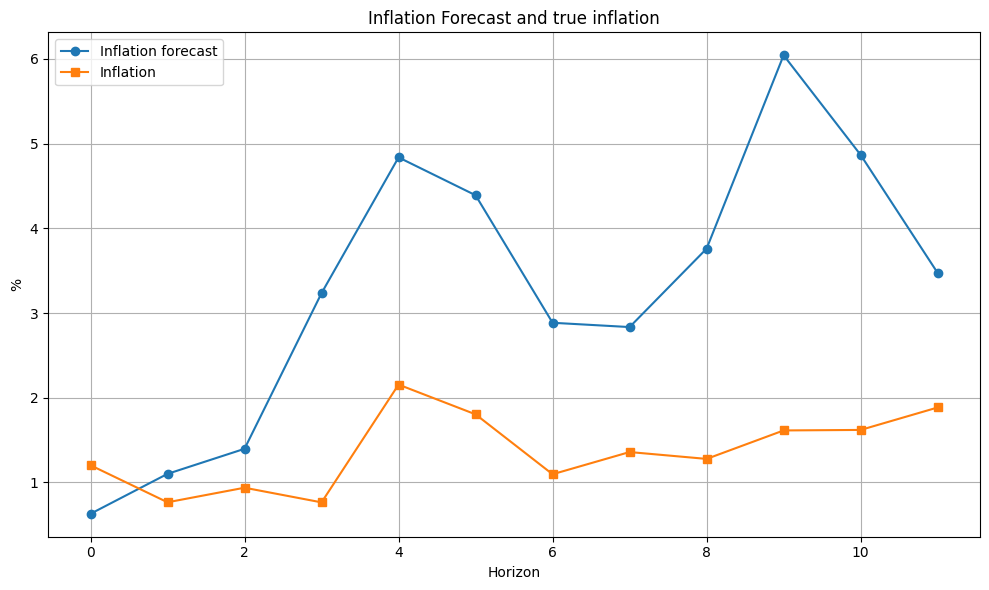

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(df_inflation['Horizon'], df_inflation['Inflation forecast'], marker='o', label='Inflation forecast')
plt.plot(df_inflation['Horizon'], df_inflation['Inflation'], marker='s', label='Inflation')
plt.xlabel('Horizon')
plt.ylabel('%')
plt.title('Inflation Forecast and true inflation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.1. Variable Selection  

For Random Forest, we extract built-in feature importance scores from each model (one per forecast horizon) and sum them to measure each variable’s total contribution across horizons. This provides a simple ranking of the most influential predictors.

In [19]:
from collections import defaultdict, Counter

# Track frequency and total importance across all horizons
feature_freq = Counter()
feature_importance = defaultdict(float)

for h, model in rf_models.items():
    importances = model.feature_importances_
    for f, imp in zip(X.columns, importances):
        if imp > 0:
            feature_freq[f] += 1
            feature_importance[f] += imp

# Combine into DataFrame
summary_rf = pd.DataFrame({
    "Frequency": pd.Series(feature_freq),
    "Total_Importance": pd.Series(feature_importance)
})

# Sort and show top features
summary_rf = summary_rf.sort_values("Total_Importance", ascending=False)
summary_rf.head(15)

,Frequency,Total_Importance
HPI,12,2.242244
N.111 Boliger,12,1.921480
Ledige kontanthjælpsmodtagere,12,1.419561
Ledige dagpengemodtagere,12,1.243074
C25 Index Value,12,0.858259
Bruttoledige,12,0.737533
P.62 Eksport af tjenester,12,0.258629
P.71 Import af varer,12,0.233990
Ejendomsforbrydelser i alt,12,0.217564
"HICP, EU (inflation)",12,0.213162


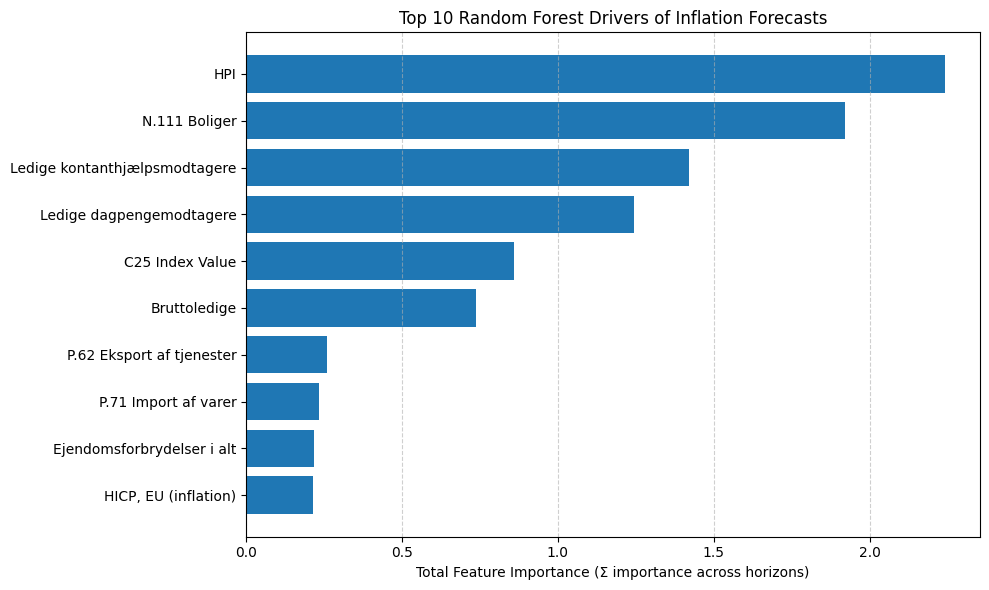

In [20]:
# Top 10 most important variables (Random Forest)
top_features = summary_rf.sort_values("Total_Importance", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features.index[::-1], top_features["Total_Importance"][::-1])
plt.xlabel("Total Feature Importance (Σ importance across horizons)")
plt.title("Top 10 Random Forest Drivers of Inflation Forecasts")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Rolling Forecasts  
### Real-Time Multi-Horizon Predictions

The function simulates how forecasts would be made in real time, one month at a time.

At each point in the forecast period, it:

1. Collects only data available up to that month (real-time assumption).
2. Fits a forecasting model using the most recent `window_length` months.
3. Generates forecasts for multiple horizons (e.g., 1 to 12 months ahead).
4. Repeats the process for every month from `start_date` to `end_date`.

The result is a rolling panel of forecasts that mimics how a forecaster would operate in practice, using only information available at the time each prediction is made.


In [22]:
forecast_results = rf_model.run_rolling_forecast(
    X=X, 
    y=y, 
    forecast_horizon=forecast_horizon,  
    start_date="2023-01-01", 
    end_date="2024-12-01", 
    trees=Trees, 
    window_length=window_length
)

# 4. Model Evaluation
## 4.1 Forecast Accuracy by Horizon

To assess how forecast performance varies across time horizons, we compute standard accuracy metrics:

- **MAE** (Mean Absolute Error): Average absolute deviation from actual inflation
- **RMSE** (Root Mean Squared Error): Penalizes large errors more heavily
- **N_obs**: Number of evaluation points for each horizon

The table below reports these metrics for each horizon \( h = 1, .. , 12 \), where horizon 0 corresponds to 1-month-ahead forecasts and horizon 11 to 12-months-ahead forecasts.

This gives a sense of how quickly forecast quality deteriorates as the prediction horizon increases.

In [25]:
eval_df, merged_df = rf_model.evaluate_forecasts(forecast_results, y)
eval_df

,Horizon,MAE,RMSE,N_obs
0,0,0.730408,1.058284,23
1,1,1.372763,1.774523,22
2,2,1.598156,2.067240,21
3,3,2.290375,2.699724,20
4,4,3.258503,3.627366,19
5,5,3.096832,3.545900,18
6,6,2.911561,3.687618,17
7,7,3.372902,4.307263,16
8,8,4.449483,5.034199,15
9,9,5.664326,5.810858,14


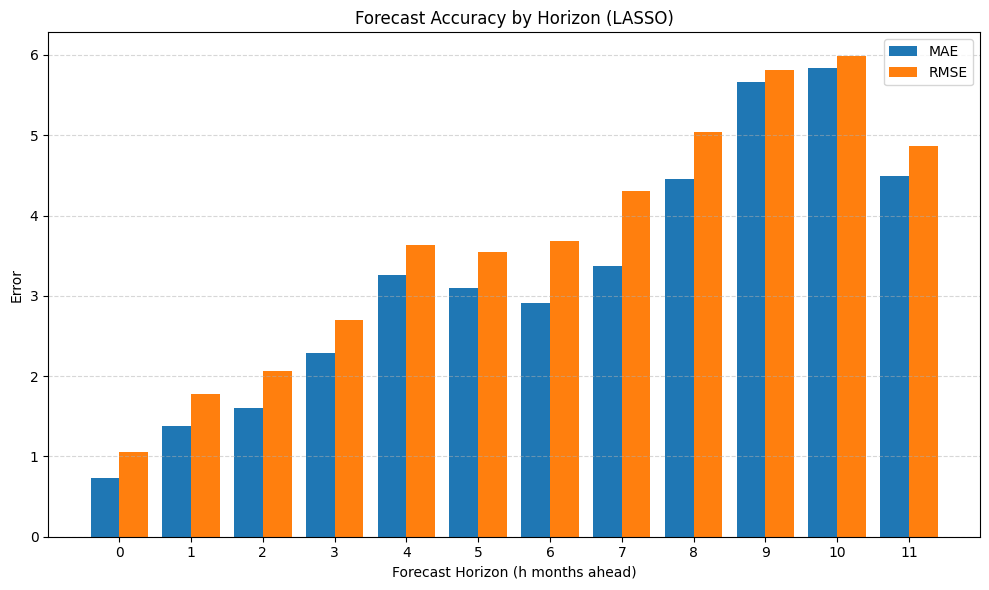

In [26]:
plt.figure(figsize=(10, 6))
h = eval_df["Horizon"]

# Plot MAE and RMSE as side-by-side bars
bar_width = 0.4
plt.bar(h - bar_width/2, eval_df["MAE"], width=bar_width, label="MAE")
plt.bar(h + bar_width/2, eval_df["RMSE"], width=bar_width, label="RMSE")

plt.xlabel("Forecast Horizon (h months ahead)")
plt.ylabel("Error")
plt.title("Forecast Accuracy by Horizon (LASSO)")
plt.xticks(h)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## 4.2. Forecast Details (Example: 1-month ahead)

We begin by isolating forecasts where the horizon is exactly 1 month (\( h = 0 \) in zero-indexed format), and merge these with actual inflation data to compute forecast errors.

We calculate and visualize:
- Raw forecast error and squared error per month
- 12-month averages to evaluate performance over time
- Numerical comparison between forecasted and actual cumulative inflation


In [29]:
h1 = merged_df[merged_df["Horizon"] == 0]
h1

,Date,Inflation forecast,Horizon,Forecast_made_in,y_true,error,abs_error,squared_error
0,2023-02-01,7.90739,0,2023-01-01,7.601,0.30639,0.30639,0.093875
12,2023-03-01,7.67317,0,2023-02-01,6.733,0.94017,0.94017,0.883920
24,2023-04-01,6.92979,0,2023-03-01,5.282,1.64779,1.64779,2.715212
36,2023-05-01,5.97595,0,2023-04-01,2.928,3.04795,3.04795,9.289999
48,2023-06-01,4.10667,0,2023-05-01,2.465,1.64167,1.64167,2.695080
60,2023-07-01,3.05291,0,2023-06-01,3.133,-0.08009,0.08009,0.006414
72,2023-08-01,3.39980,0,2023-07-01,2.437,0.96280,0.96280,0.926984
84,2023-09-01,2.85340,0,2023-08-01,0.859,1.99440,1.99440,3.977631
96,2023-10-01,1.57527,0,2023-09-01,0.085,1.49027,1.49027,2.220905
108,2023-11-01,0.71268,0,2023-10-01,0.600,0.11268,0.11268,0.012697


#### Annualized Inflation Comparison

To evaluate the forecast model over longer horizons, we compute the average annualized inflation for two distinct 12-month periods. 
For each period, we calculate the average of the forecasted monthly inflation and compare it to the average of the actual inflation.

This gives a sense of how well the Random forrest algoritme tracks long-run inflation dynamics over time.


In [31]:
# Define periods and corresponding years
periods = {
    "2023": slice(0, 12),
    "2024": slice(12, 24)
}

# Compute and print average inflation per year
for year, s in periods.items():
    forecast_avg = h1["Inflation forecast"].iloc[s].mean()
    actual_avg = h1["y_true"].iloc[s].mean()

    print(f"\n=== {year} ===")
    print(f"Forecasted avg. inflation: {forecast_avg:.3f}")
    print(f"Actual avg. inflation:     {actual_avg:.3f}")
    print(f"Forecast error (pp):       {forecast_avg - actual_avg:.3f}")


=== 2023 ===
Forecasted avg. inflation: 3.796
Actual avg. inflation:     2.835
Forecast error (pp):       0.961

=== 2024 ===
Forecasted avg. inflation: 1.448
Actual avg. inflation:     1.389
Forecast error (pp):       0.059


#### Forecast Error Over Time (h = 1)
The chart below shows the monthly forecast error and squared error for the 1-month-ahead horizon.  
It helps visualize the timing and severity of forecast deviations throughout the period.

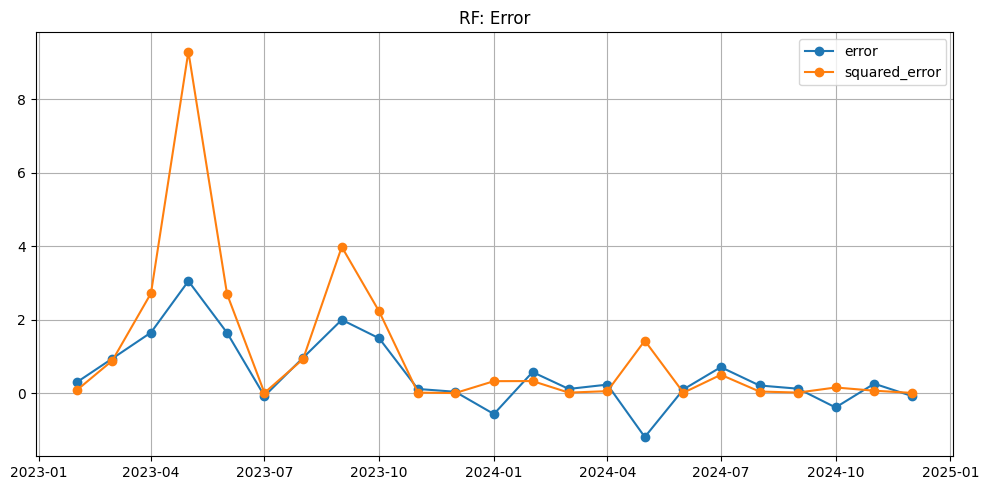

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Date"], h1["error"], label="error", marker="o")
#plt.plot(h1["Date"], h1["abs_error"], label="abs_error", marker="o")
plt.plot(h1["Date"], h1["squared_error"], label="squared_error", marker="o")
plt.legend()
plt.title("RF: Error")
plt.grid(True)
plt.tight_layout()
plt.show()

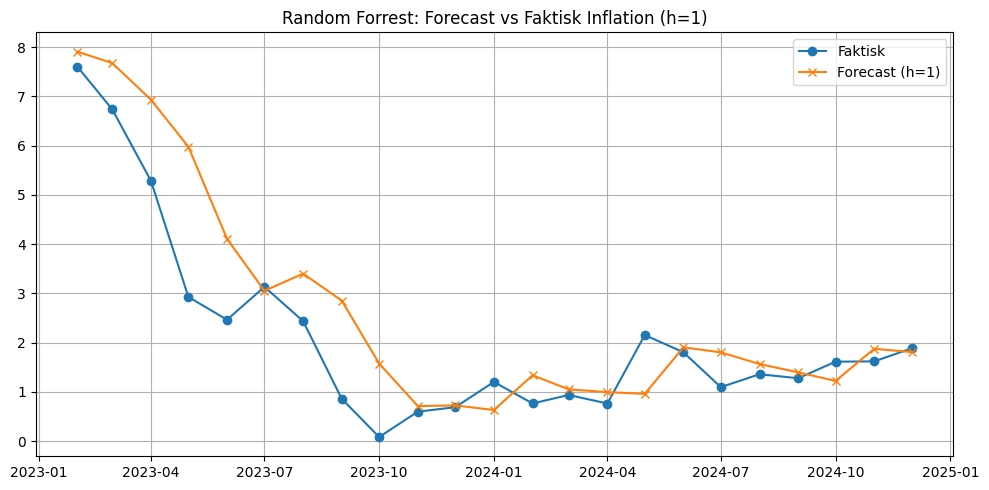

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Date"], h1["y_true"], label="Faktisk", marker="o")
plt.plot(h1["Date"], h1["Inflation forecast"], label="Forecast (h=1)", marker="x")
plt.legend()
plt.title("Random Forrest: Forecast vs Faktisk Inflation (h=1)")
plt.grid(True)
plt.tight_layout()
plt.show()